In [15]:
from datasets import generate_x_y_data_v2 as generate_data
import numpy as np
import matplotlib.pyplot as plt

In [16]:
sample_x, sample_y = generate_data(isTrain=True, batch_size=3)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

Dimensions of the dataset for 3 X and 3 Y training examples : 
(15, 3, 1)
(15, 3, 1)
(seq_length, batch_size, output_dim)


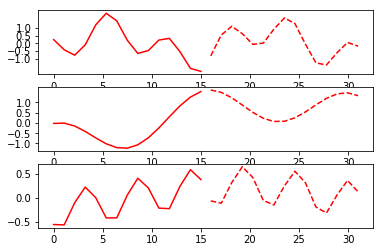

In [17]:
import math

plt.figure()
x_axis = np.linspace(0, 15, 15)
for i in range(3):
    plt.subplot(311+i)
    plt.yticks(np.linspace(-1,1,5))
    plt.plot(x_axis, sample_x[:, i, 0], 'r')
    plt.plot(x_axis+16, sample_y[:, i, 0], 'r--')

plt.show()

In [54]:
from model.decoders import Decoder
from model.encoders import Encoder
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

class Model(nn.Module):
    def __init__(self, 
                 input_size,
                 hidden_size,
                 output_size,
                 encoder_dropout=0,
                 decoder_dropout=0,
                 number_of_layers=1,
                 output_length=10):
        super(Model, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, dropout=encoder_dropout, 
                               number_of_layers=number_of_layers
                              )
        
        self.decoder = Decoder(hidden_size, hidden_size, output_size, 
                               dropout=decoder_dropout, 
                               number_of_layers=number_of_layers
                              )
        
        self.output_length = output_length
        self.number_of_layers = number_of_layers
        self.hidden_size = hidden_size
        
    def forward(self, x):
        encoder_output, encoder_state = self.encoder(x, None)
        decoder_input = torch.unsqueeze(encoder_output[-1], 0)
        
        seq = []
        next_hidden=None
        next_input = decoder_input
        for _ in range(self.output_length):
            output, next_input, next_hidden = self.decoder(next_input, next_hidden)
            seq += [output]
        return torch.stack(seq, dim=0).squeeze()


In [55]:
# Internal neural network parameters
# Time series will have the same past and future (to be predicted) lenght.
seq_length = sample_x.shape[0]
batch_size = 50  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

# Output dimension (e.g.: multiple signals at once, tied in time)
output_dim = input_dim = sample_x.shape[-1]
print(sample_x.shape)
hidden_dim = 35  # Count of hidden neurons in the recurrent units.
# Number of stacked recurrent cells, on the neural depth axis.
layers_stacked_count = 2

# Optmizer:
learning_rate = 0.007  # Small lr helps not to diverge during training.
# How many times we perform a training step (therefore how many times we
# show a batch).
nb_iters = 2500
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

(15, 3, 1)


In [60]:
model = Model(input_dim, hidden_dim, output_dim, number_of_layers=layers_stacked_count, output_length=seq_length)

step: 0 , loss: 0.448125


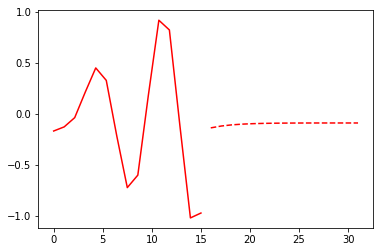

step: 500 , loss: 0.301106


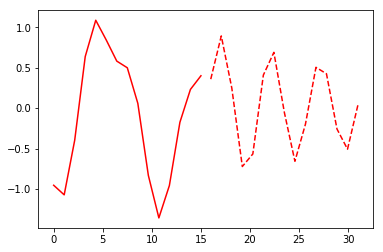

step: 1000 , loss: 0.274498


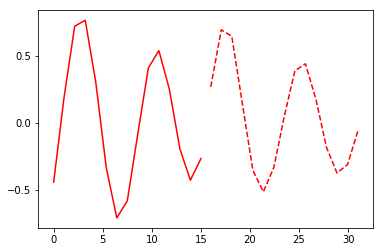

step: 1500 , loss: 0.249097


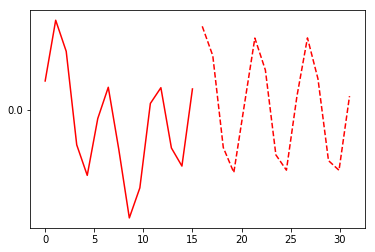

step: 2000 , loss: 0.218865


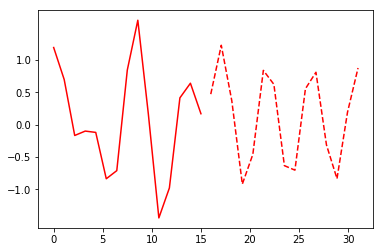

step: 2500 , loss: 0.22204


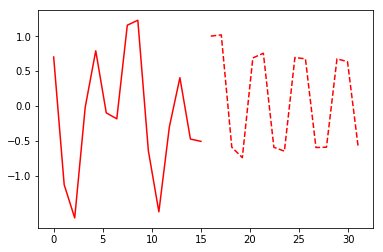

In [61]:
target_x = x_axis+16
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
for step in range(nb_iters + 1):
    temp_x, temp_y = generate_data(isTrain=True, batch_size=batch_size)
    x = autograd.Variable(torch.FloatTensor(temp_x), requires_grad=False)
    y = autograd.Variable(torch.FloatTensor(temp_y), requires_grad=False)
    optimizer.zero_grad()
    prediction = model(x)   # rnn output
    loss = loss_func(prediction, y)
    if step % 500 == 0:
        print('step:', step, ', loss:', loss.data.numpy()[0])
        plot_y = prediction.data.numpy()
        plt.figure()
        plt.yticks(np.linspace(-1,1,5))
        plt.plot(x_axis, temp_x[:, i, 0], 'r')
        plt.plot(target_x, plot_y[:, i], 'r--')
        plt.show()
    loss.backward()
    optimizer.step()

In [62]:
temp_x, temp_y = generate_data(isTrain=False, batch_size=1)
x = autograd.Variable(torch.FloatTensor(temp_x), requires_grad=False)
y = autograd.Variable(torch.FloatTensor(temp_y), requires_grad=False)
prediction = model(x)
prediction = prediction.data.numpy()
print(temp_x.shape)
print(prediction.shape)

(15, 1, 1)
(15,)


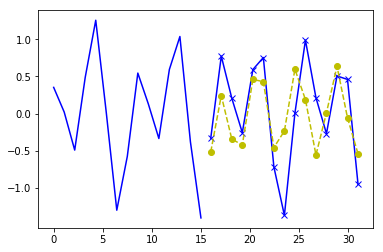

In [63]:
plt.figure()
x_axis = np.linspace(0, 15, 15)
plt.yticks(np.linspace(-1,1,5))
plt.plot(x_axis, temp_x[:, 0, 0], 'b')
target_x = x_axis+16

plt.plot(target_x, temp_y[:, 0, 0], 'bx-')
plt.plot(target_x, prediction, 'yo--')
plt.show()